<a href="https://colab.research.google.com/github/NaoDekoNeko/MateComputacional/blob/main/EX_FINAL_MC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examen Final de Matemática computacional

## Alumnos:

### Gabriel Barrientos Cárdenas 20192174G
### Ademar Fatama Ruiz	20192148F

# Problema de camión de madera

## Preparaciones

In [ ]:
pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 38.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pulp
import pandas as pd
import time

def GeneradorKp(N,V):
    A = [list(np.random.randint(6,24,size=N))]
    c = list(np.random.randint(3,12,size=N))
    return A,[V],c

def CreateDictionary():
    dic = {
        "Algoritmo":[],
        "N Tablas":[],
        "tiempo":[],
        "Area Maxima":[],
        "Volumen Solucion":[] ,
        "Solucion": []
    }
    return dic

def Area(X,c):
    return sum(np.array(X)*np.array(c))

def Volumen(X0,A):
    sV=0
    for i,s in enumerate(X0):
        if s == 1:
          sV += A[0][i]
    return sV

## Metaheuristica (ILS)

In [ ]:
def GetVecino(X0):
    N =len(X0)
    Xv = X0.copy()
    i = np.random.randint(N)
    if Xv[i] == 1: Xv[i] = 0
    else: Xv[i]  = 1
    return Xv

def Perturbar(X):
    return list(np.random.randint(0,2,size=N))

def ILS_Exploracion(X0,c,b,maxArea):
    i=0
    while (i < 200):
      Xv = GetVecino(X0)
      Av = Area(Xv,c)
      Vv = Volumen(Xv,A)
      if ( Av > maxArea and Vv <= b[0] ):
        X0 = Xv
      i+=1
    return X0

def FillResults(dic,tiempo,Area,Solucion,V,N):
    dic["tiempo"].append(tiempo)
    dic["Area Maxima"].append(Area)
    dic["N Tablas"].append(N)
    dic["Solucion"].append(Solucion)
    dic["Volumen Solucion"].append(V)

def MetaheuristicaKP(c, A, b):
    dic = CreateDictionary()
    dic["Algoritmo"].append("Metaheuristica KP Camion")
    inicio = time.time()
    N = len(c)
    while True:
      X0 = list(np.random.randint(0,2,size=N))
      A0 = Area(X0,c)
      V0 = Volumen(X0,A)
      if(V0 <= b[0]) : break

    i=0
    while(i<500):
      xP = Perturbar(X0)
      Ap = Area(xP,c)
      Vp = Volumen(xP,A)
      if Ap >  A0 and Vp <= b[0]:
        X0 = xP
        A0 = Area(X0,c)
        X0 = ILS_Exploracion(X0,c,b,A0)
      i+=1
    sV = Volumen(X0,A)
    fin = time.time()
    T = fin-inicio
    FillResults(dic,T,Area(X0,c),X0,sV,N)
    df_resultado = pd.DataFrame(dic)
    return df_resultado

## Simplex

In [ ]:
def AlgoritmoSimplex_KP(c, A, b,objetivo="max"):
    dic = CreateDictionary()
    dic["Algoritmo"].append("Simplex KP Camion")

    inicio = time.time()
    # Verificar el objetivo y crear un problema de PuLP correspondiente
    if objetivo.lower() == "max":
       prob = pulp.LpProblem("MaximizationProblem", pulp.LpMaximize)
    elif objetivo.lower() == "min":
       prob = pulp.LpProblem("MinimizationProblem", pulp.LpMinimize)
    else:
       raise ValueError("El parámetro 'objetivo' debe ser 'max' o 'min'")
    # Crear variables
    n = len(c)
    x = [pulp.LpVariable(f"x{i}", cat=pulp.LpBinary) for i in range(n)]
    # Definir la función objetivo
    if objetivo.lower() == "max":
       prob += pulp.lpSum(c[i] * x[i] for i in range(n)), "ObjectiveFunction"
    elif objetivo.lower() == "min":
       prob += pulp.lpSum(-c[i] * x[i] for i in range(n)), "ObjectiveFunction"
    # Definir las restricciones
    for i in range(len(A)):
       prob += pulp.lpSum(A[i][j] * x[j] for j in range(n)) <= b[i], f"Constraint{i}"
    # Resolver el problema con el solucionador CBC
    prob.solve(pulp.PULP_CBC_CMD())
    # Obtener el estado, el valor óptimo y las soluciones de las variables
    if objetivo.lower() == "max":
       valor_optimo = pulp.value(prob.objective)
    elif objetivo.lower() == "min":
       valor_optimo = -pulp.value(prob.objective)
    soluciones = [int(x[i].varValue) for i in range(n)]
    fin = time.time()
    T = fin-inicio

    sV = Volumen(soluciones,A)
    FillResults(dic,T,valor_optimo,soluciones,sV,n)
    df_resultado = pd.DataFrame(dic)
    return df_resultado

## Comparacion

In [ ]:
def FillResults_Comparation(dic,list_df):
    for df in list_df:
      dic["Algoritmo"].append(df["Algoritmo"][0])
      dic["N Tablas"].append(df["N Tablas"][0])
      dic["tiempo"].append(df["tiempo"][0])
      dic["Area Maxima"].append(df["Area Maxima"][0])
      dic["Solucion"].append(df["Solucion"][0])
      dic["Volumen Solucion"].append(df["Volumen Solucion"][0])

dic = CreateDictionary()
def Comparacion_Simplex_Heuristica(c,A,b):
    df_Simplex = AlgoritmoSimplex_KP(c,A,b, objetivo="max")
    df_MH = MetaheuristicaKP(c,A,b)
    FillResults_Comparation(dic,[df_Simplex,df_MH])

for i in range(4,24):
  N = i
  V = 56
  A,b,c = GeneradorKp(N,V)
  Comparacion_Simplex_Heuristica(c,A,b)

_df_24 = pd.DataFrame(dic)
_df_24

,Algoritmo,N Tablas,tiempo,Area Maxima,Volumen Solucion,Solucion
0,Simplex KP Camion,4,0.019812,20.0,44,"[1, 1, 1, 0]"
1,Metaheuristica KP Camion,4,0.044169,20.0,44,"[1, 1, 1, 0]"
2,Simplex KP Camion,5,0.032389,26.0,52,"[0, 1, 0, 1, 1]"
3,Metaheuristica KP Camion,5,0.042835,26.0,52,"[0, 1, 0, 1, 1]"
4,Simplex KP Camion,6,0.032308,33.0,51,"[1, 1, 0, 1, 1, 0]"
5,Metaheuristica KP Camion,6,0.046031,33.0,51,"[1, 1, 0, 1, 1, 0]"
6,Simplex KP Camion,7,0.050193,29.0,49,"[1, 1, 1, 1, 0, 0, 0]"
7,Metaheuristica KP Camion,7,0.075251,29.0,49,"[1, 1, 1, 1, 0, 0, 0]"
8,Simplex KP Camion,8,0.024718,32.0,54,"[1, 0, 1, 0, 0, 0, 1, 1]"
9,Metaheuristica KP Camion,8,0.062405,32.0,54,"[1, 0, 1, 0, 0, 0, 1, 1]"


## Gráfico Tiempo vs Área

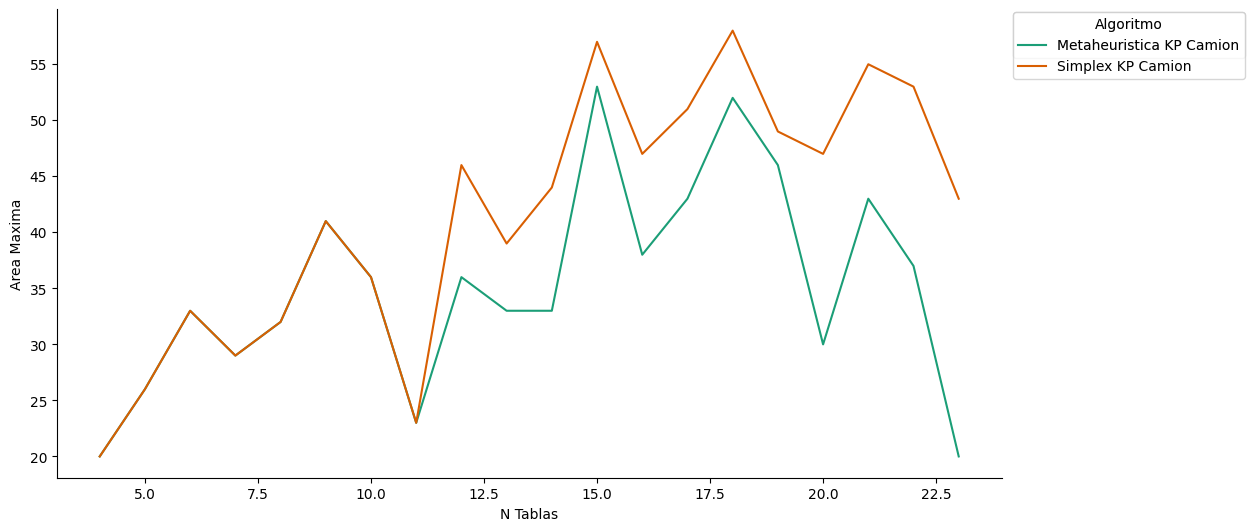

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['N Tablas']
  ys = series['Area Maxima']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_24.sort_values('N Tablas', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Algoritmo')):
  _plot_series(series, series_name, i)
  fig.legend(title='Algoritmo', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('N Tablas')
_ = plt.ylabel('Area Maxima')

# Problema de ruteo de vehículos

## Mostrar rutas

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

def PintarCamino(G, pos, matriz, i, color):
    indice = i
    n = np.shape(matriz)[0]
    if G.has_edge(0, i):
                    nx.draw_networkx_edges(G, pos, edgelist=[(0, indice)], edge_color=color, width=2)

    while True:
        for j in range(n):
            if matriz[indice][j] == 1:
                # Verifica si la arista existe en el grafo antes de dibujarla
                if G.has_edge(indice, j):
                    nx.draw_networkx_edges(G, pos, edgelist=[(indice, j)], edge_color=color, width=2)
                    ind_fin = indice
                    indice = j
                    break

        if indice == 0:
            break

def generarPaleta(k):
    # Utiliza la paleta "Set1" de seaborn, que contiene hasta 9 colores.
    # Si k es mayor que 9, se repetirán algunos colores.
    return sns.color_palette("Set1", n_colors=k)

def dibujar_grafo_con_pesos(matriz, pesos,k):
    G = nx.DiGraph()  # Crea un grafo dirigido
    n = len(matriz)

    for i in range(n):
        for j in range(n):
            if matriz[i][j] == 1:
                G.add_edge(i, j, weight=pesos[i][j])  # Añade una arista de i a j con su peso

    pos = nx.circular_layout(G)  # Posiciona los nodos en un círculo
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=150,font_size=6)

    # Añade los pesos de las aristas al gráfico
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)



    #Pintamos cada subruta de un vehiculo de los k vehiculos
    color = generarPaleta(k)
    l = 0
    for i in range(n):
      if matriz[0][i] == 1:
        PintarCamino(G,pos,matriz,i,color[l])
        l+=1

    plt.show()

## Metaheurísitca (ILS)

In [ ]:
from tabulate import tabulate
import warnings
import numpy as np
import time
import pandas as pd

# La suma de los arcos (j) que salen de (i)
def FirstRestriction(x):
    # No se incluye al nodo almacen (0)
    return np.all(np.sum(x[1:, :], axis=1) == 1)

# La suma de los arcos (i) que entran a (j)
def SecondRestriction(x):
    # No se incluye al nodo almacen (0)
    return np.all(np.sum(x[:, 1:], axis=0) == 1)

# La suma de todo arco (j) que sale de (0)
def ThirdRestriction(x, k):
    #La suma debe ser igual a V
    return np.sum(x[0, 1:]) == k
# La suma de todo arco (j) que entra a (0)
def FourthRestriction(x, k):
    #La suma debe ser igual a V
    return np.sum(x[1:, 0]) == k

def FifthRestriction(x,n):
    for i in range(1,n):
      for j in range(1,n):
        s = 0
        if i!=j:
          s+=x[i][j] + x[j][i]
          if s>1:
            return False
    return True

def CheckRestrictions(X, N, k):
    cond1 = FirstRestriction(X)
    cond2 = SecondRestriction(X)
    cond3 = ThirdRestriction(X, k)
    cond4 = FourthRestriction(X, k)
    cond5 = FifthRestriction(X,N)
    return cond1 and cond2 and cond3 and cond4 and cond5

def Costo(X, W):
    return np.sum(X * W)

def Matriz_W(n):
  W = np.random.randint(1,20,size = (n,n))
  W = ( W + W.T )//2
  np.fill_diagonal(W,0)
  return W

def Perturbamos(N,k):
    # Inicializa la matriz con ceros
    X = np.zeros((N, N), dtype=int)
    # Valores de i
    list_i = list(range(1,N))

    # Valores de j
    list_j = list(range(1,N))

    #Rellenamos la fila 0 con k 1s
    ind_f0 = np.random.choice(list_j, k, replace=False)

    for i in ind_f0:
      X[0][i] =1

    # Quitamos los valores de la lista j
    list_j = [elemento for elemento in list_j if elemento not in ind_f0]

    # Quitamos los valores de la lista i
    list_i = [elemento for elemento in list_i if elemento not in ind_f0]
    # Escogemos el valor aleatorio
    ind_c0= np.random.choice(list_i, k, replace=False)
    # Rellenamos la columna 0 con k 1s
    for i in ind_c0:
      X[i][0] =1

    #Filas restantes
    rest_j = [elemento for elemento in range(1,N) if elemento not in ind_f0]
    rest_i = [elemento for elemento in range(1,N) if elemento not in ind_c0]

    while rest_i:
      i = np.random.choice(rest_i, 1, replace=False)
      rest_i = [elemento for elemento in rest_i if elemento not in i]
      rest_j_ax = [elemento for elemento in rest_j if elemento not in i]

      if rest_j_ax:
        j = np.random.choice(rest_j_ax, 1, replace=False)
        rest_j = [elemento for elemento in rest_j if elemento not in j]
        X[i[0]][j[0]]=1
    return X

def Exploramos(x0):
    N = np.shape(x0)[0]

    ind_f0 = [indice for indice in range(1,N) if x0[0][indice]==1]
    ind_c0 = [indice for indice in range(1,N) if x0[indice][0]==1]

    xV = x0.copy()

    for i in range(1,N):
      for j in range(1,N):
        xV[i][j]=0

    #Filas restantes
    rest_j = [elemento for elemento in range(1,N) if elemento not in ind_f0]
    rest_i = [elemento for elemento in range(1,N) if elemento not in ind_c0]

    while rest_i:
      i = np.random.choice(rest_i, 1, replace=False)

      rest_i = [elemento for elemento in rest_i if elemento not in i]
      rest_j_ax = [elemento for elemento in rest_j if elemento not in i]

      if rest_j_ax:
        j = np.random.choice(rest_j_ax, 1, replace=False)
        rest_j = [elemento for elemento in rest_j if elemento not in j]
        xV[i[0]][j[0]]=1

    return xV

def generar_Xij(N, k, W,X_ant,costoMin,verbose=False):
    # Escogemos un valor X0
    explorar=True
    X0 = Perturbamos(N,k)
    W0 = Costo( X0 , W )
    if CheckRestrictions(X0, N, k)!=True:
       explorar=False
    elif W0 < costoMin:
      if verbose: print(f"W0 < costoMin : {W0} < {costoMin}")
      i=0
      ind = -1
      while(i < 100 and explorar):
        #Exploramos un vecino aleatorio
        Xv = Exploramos(X0)
        Wv = Costo(Xv, W)
        if CheckRestrictions(Xv, N, k)!=True:
          if verbose: print(f" [-] Exploracion {i} no Factible - Costo xV: {Wv}")
        elif Wv < W0:
          X0 = Xv
          W0 = Costo( X0 , W ) #Actualizamos el peso de X0
          ind = i
          if verbose: print(f"[+] Exploracion {i} Aceptable - Costo Wv : {Wv} < Costo W0:{W0}")
        else:
          if verbose: print(f"[-] Exploracion {i}- Costo Wv : {Wv} > Costo W0:{W0}")
        i+=1
      if verbose: print(f"[-] Costomin de {i} Exploraciones - Costo Wv({ind}) : {W0}")
      if ind!=-1:
        return X0
    return X_ant

# Desactivar FutureWarnings de tabulate
warnings.simplefilter(action='ignore', category=FutureWarning)

def FillResults_VRP(dic,nodos,tiempo,minCosto):
    dic["Nodos"].append(nodos)
    dic["Tiempo"].append(tiempo)
    dic["Minimo_Costo"].append(minCosto)


def MetaHeuristic_VRP(W, k, verbose = False):
    if verbose :print("=== MetaHeuristic_VRP ===\n")
    # inicio del tiempo
    inicio = time.time()

    #Creamos un diccionario
    d_Solucion = {
        "Algoritmo":["Metaheuristica- ILP"],
        "Nodos":[],
        "Tiempo":  [],
        "Minimo_Costo": []
    }

    # Almacenamos el N
    N, _ = np.shape(W)

    # Generamos posibles soluciones
    minCosto = float('inf')
    Posibles_Xij =[]
    X = Perturbamos(N,k)
    for i in range(500):
      X = generar_Xij(N, k,W,X,minCosto,verbose=verbose)
      minCosto = Costo(X,W)
      Posibles_Xij.append(X)

    # Variable solución
    S = X.copy()
    minCosto=Costo(S,W)

    fin = time.time()

    # Calculamos el tiempo
    T_time = fin - inicio

    FillResults_VRP(d_Solucion,N,T_time,minCosto)
    #creamos el dataframe
    df_results = pd.DataFrame(d_Solucion)

    if verbose:
      # Mostramos Solucion
      print(f" [+] Tiempo : {T_time} s")
      print(f" [+] Costo Minimo : {minCosto}")
      print(f" [+] Solución : \n\n")
      dibujar_grafo_con_pesos(S,W,k)
    return S,df_results

# Ejemplo

=== MetaHeuristic_VRP ===

W0 < costoMin : 144 < inf
[+] Exploracion 0 Aceptable - Costo Wv : 140 < Costo W0:140
[-] Exploracion 1- Costo Wv : 144 > Costo W0:140
[-] Exploracion 2- Costo Wv : 144 > Costo W0:140
[-] Exploracion 3- Costo Wv : 151 > Costo W0:140
[-] Exploracion 4- Costo Wv : 142 > Costo W0:140
[-] Exploracion 5- Costo Wv : 144 > Costo W0:140
[-] Exploracion 6- Costo Wv : 141 > Costo W0:140
[-] Exploracion 7- Costo Wv : 150 > Costo W0:140
[-] Exploracion 8- Costo Wv : 140 > Costo W0:140
[-] Exploracion 9- Costo Wv : 143 > Costo W0:140
[-] Exploracion 10- Costo Wv : 143 > Costo W0:140
[-] Exploracion 11- Costo Wv : 144 > Costo W0:140
[-] Exploracion 12- Costo Wv : 146 > Costo W0:140
[+] Exploracion 13 Aceptable - Costo Wv : 137 < Costo W0:137
[-] Exploracion 14- Costo Wv : 143 > Costo W0:137
[-] Exploracion 15- Costo Wv : 148 > Costo W0:137
[-] Exploracion 16- Costo Wv : 139 > Costo W0:137
[-] Exploracion 17- Costo Wv : 146 > Costo W0:137
[-] Exploracion 18- Costo Wv : 147 

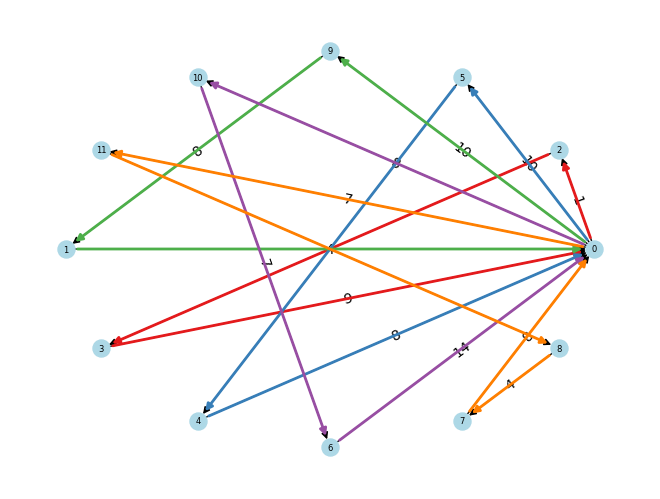

,Algoritmo,Nodos,Tiempo,Minimo_Costo
0,Metaheuristica- ILP,12,0.584207,115


In [ ]:
N = 12
W = Matriz_W(N)
W0 = W

k = 5
X_sol,df_metaheuristica = MetaHeuristic_VRP(W0, k,verbose = True)
df_metaheuristica

## Simplex

In [ ]:
from pulp import *
import numpy as np
import time

def FillResults_VRP_simplex(dic,nodos,tiempo,minCosto):
    dic["Nodos"].append(nodos)
    dic["Tiempo"].append(tiempo)
    dic["Minimo_Costo"].append(minCosto)

def Simplex_Entera(W,k):
  #n
  n = np.shape(W)[0]
  # Definir el problema
  prob = LpProblem("Mi problema", LpMinimize)

  # Variables
  x = [[LpVariable(f'x_{i}_{j}', 0, 1, LpBinary) for j in range(n)] for i in range(n)]

  # Función objetivo
  prob += lpSum(W[i][j] * x[i][j] for i in range(n) for j in range(n))  # Aquí puedes definir tu propia función objetivo

  # Restricciones
  for i in range(1, n):
      prob += lpSum(x[i][j] for j in range(n) if j != i) == 1

  for j in range(1, n):
      prob += lpSum(x[i][j] for i in range(n) if i != j) == 1

  prob += lpSum(x[0][j] for j in range(1, n)) == k
  prob += lpSum(x[j][0] for j in range(1, n)) == k

  for i in range(1, n):
      for j in range(1, n):
          if i != j:
              prob += x[i][j] + x[j][i] <= 1

  # Resolver el problema
  # Calculamos el tiempo
  inicio = time.time()
  prob.solve()

  # Imprimir el estado del problema
  print("Estado:", LpStatus[prob.status])

  X = np.zeros((n ,n ))

  # Imprimir las variables de decisión
  for i in range(n):
      for j in range(n):
          if i!=j:
            X[i][j] = x[i][j].varValue

  fin = time.time()
  # Calculamos el tiempo
  T_time = fin - inicio

  minCosto = np.sum(X*W)
  #Creamos un diccionario
  d_Solucion = {
        "Algoritmo":["Simplex-Entera"],
        "Nodos":[],
        "Tiempo":  [],
        "Minimo_Costo": []
    }
  FillResults_VRP_simplex(d_Solucion,n,T_time,minCosto)
  df_results = pd.DataFrame(d_Solucion)

  return X,df_results

## Comparación

In [ ]:
def FillDic_VRP_comparation(dic,list_dic):
    for df in list_dic:
      dic["Algoritmo"].append(df["Algoritmo"][0])
      dic["Nodos"].append(df["Nodos"][0])
      dic["Tiempo"].append(df["Tiempo"][0])
      dic["Minimo_Costo"].append(df["Minimo_Costo"][0])


def Comparacion_Simplex_Heuristica_VRP(k):
    d={
        "Algoritmo":[],
        "Nodos": [],
        "Tiempo": [],
        "Minimo_Costo":[]
    }

    for i in range(11,30):
      Wi = Matriz_W(i)
      W0 = Wi.copy()
      X,df_results= Simplex_Entera(W0,k)

      X_sol,df_meta = MetaHeuristic_VRP(W0,k)
      df_r = [df_results,df_meta]
      FillDic_VRP_comparation(d,df_r)

    return pd.DataFrame(d)

In [ ]:
_df_7 = Comparacion_Simplex_Heuristica_VRP(4)

/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estado: Optimal


In [ ]:
_df_7

,Algoritmo,Nodos,Tiempo,Minimo_Costo
0,Simplex-Entera,11,0.012512,112.0
1,Metaheuristica- ILP,11,0.647362,125.0
2,Simplex-Entera,12,0.013389,84.0
3,Metaheuristica- ILP,12,0.538877,101.0
4,Simplex-Entera,13,0.014384,86.0
5,Metaheuristica- ILP,13,0.821787,116.0
6,Simplex-Entera,14,0.021136,90.0
7,Metaheuristica- ILP,14,0.851612,139.0
8,Simplex-Entera,15,0.016605,105.0
9,Metaheuristica- ILP,15,1.057195,148.0


## Grafica #nodos vs costo mínimo

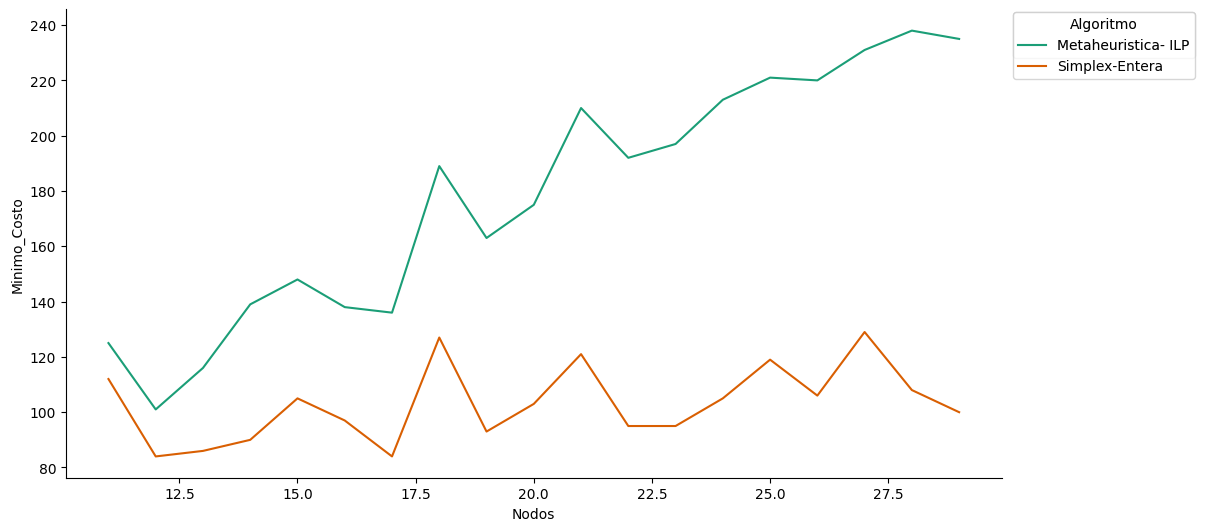

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Nodos']
  ys = series['Minimo_Costo']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('Nodos', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Algoritmo')):
  _plot_series(series, series_name, i)
  fig.legend(title='Algoritmo', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Nodos')
_ = plt.ylabel('Minimo_Costo')